# Домашнее задание 5. Анализ данных на Spark SQL

**Цель задания:** Научиться работать с основными операторами Spark SQL, фильтровать таблицы по разным условиям, писать вложенные запросы, объединять таблицы.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

try:
    active_session = SparkSession.getActiveSession()
    if active_session is not None:
        active_session.stop()

    sc = SparkContext._active_spark_context
    if sc is not None:
        sc.stop()
except Exception as e:
    print(e)


spark = (
    SparkSession.builder
    .appName("hw5")
    .config("spark.ui.port", "9311")
    .config("spark.sql.warehouse.dir", "file:///tmp/spark-warehouse")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .master("local[*]")
    .getOrCreate()
)

display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 18:51:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def run_and_display(query: str, limit: int = None) -> None:
    """Execute Spark SQL and display result as a formatted table."""
    df = spark.sql(query)
    if limit is not None:
        pdf = df.limit(limit).toPandas().fillna(0)
    else:
        pdf = df.toPandas().fillna(0)
        
    display(pdf)

## Шаг 1. Создание таблицы logs_hotel из CSV-файла

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Определение схемы таблицы logs_hotel
schema = StructType([
    StructField("ID", StringType(), True),
    StructField("n_adults", IntegerType(), True),
    StructField("n_children", IntegerType(), True),
    StructField("weekend_nights", IntegerType(), True),
    StructField("week_nights", IntegerType(), True),
    StructField("meal_plan", StringType(), True),
    StructField("car_parking_space", IntegerType(), True),
    StructField("room_type", StringType(), True),
    StructField("lead_time", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("date", IntegerType(), True),
    StructField("market_segment", StringType(), True),
    StructField("repeated_guest", IntegerType(), True),
    StructField("previous_cancellations", IntegerType(), True),
    StructField("previous_bookings_not_canceled", IntegerType(), True),
    StructField("avg_room_price", DoubleType(), True),
    StructField("special_requests", IntegerType(), True),
    StructField("status", StringType(), True),
])

# Загрузка данных из CSV
logs_hotel_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "false") \
    .schema(schema) \
    .csv("data/hotels.csv")

# Создание временного представления
logs_hotel_df.createOrReplaceTempView("logs_hotel")

print(f"Таблица logs_hotel создана: {logs_hotel_df.count()} записей")

sql = """
SELECT year, month, date, COUNT(*) as count
FROM logs_hotel 
WHERE month = 2 AND date > 28
GROUP BY year, month, date
"""

run_and_display(sql)

Таблица logs_hotel создана: 36275 записей


,year,month,date,count
0,2018,2,29,37


С данными определённо не всё в порядке.

## Шаг 2. Создание таблицы calendar с датами 2017-01-01 по 2018-12-31

In [4]:
calendar_df = spark.sql("""
    SELECT 
        date_format(calendar_dt, 'yyyy-dd-MM') as calendar_dt
    FROM (
        SELECT 
            explode(sequence(
                to_date('2017-01-01'),
                to_date('2018-12-31'),
                interval 1 day
            )) as calendar_dt
    )
""")

calendar_df.createOrReplaceTempView("calendar")
print(f"Таблица calendar создана: {calendar_df.count()} записей")

Таблица calendar создана: 730 записей


## Запрос 1. Вычислить среднее количество ночей, которые гости проводят в отеле (только для подтвержденных бронирований, с детализацией по месяцам и годам)

In [5]:
sql = """
WITH bookings AS (
    SELECT 
        year,
        month,
        weekend_nights + week_nights as total_nights,
        make_date(year, month, CASE WHEN month = 2 AND date > 28 THEN 28 ELSE date END) as checkin_date,
        date_add(
            make_date(year, month, CASE WHEN month = 2 AND date > 28 THEN 28 ELSE date END),
            weekend_nights + week_nights
        ) as checkout_date
    FROM logs_hotel
    WHERE status = 'Not_Canceled'
)
SELECT 
    year,
    month,
    ROUND(AVG(datediff(checkout_date, checkin_date)), 2) as avg_nights_by_dates_diff,
    ROUND(AVG(total_nights), 2) as avg_nights
FROM bookings
GROUP BY year, month
ORDER BY year, month
"""

run_and_display(sql)

,year,month,avg_nights_by_dates_diff,avg_nights
0,2017,7,3.02,3.02
1,2017,8,2.72,2.72
2,2017,9,2.66,2.66
3,2017,10,2.70,2.70
4,2017,11,2.72,2.72
5,2017,12,3.04,3.04
6,2018,1,2.74,2.74
7,2018,2,2.69,2.69
8,2018,3,3.04,3.04
9,2018,4,2.92,2.92


## Запрос 2. Определить ТОП-3 месяца по проценту отмененных броней за 2018 год

In [6]:
sql = """
SELECT 
    month,
    COUNT(*) as total_bookings,
    SUM(CASE WHEN status = 'Canceled' THEN 1 ELSE 0 END) as canceled_bookings,
    ROUND(
        100.0 * SUM(CASE WHEN status = 'Canceled' THEN 1 ELSE 0 END) / COUNT(*), 
        2
    ) as cancellation_rate_pct
FROM logs_hotel
WHERE year = 2018
GROUP BY month
ORDER BY cancellation_rate_pct DESC
LIMIT 3
"""

run_and_display(sql)

,month,total_bookings,canceled_bookings,cancellation_rate_pct
0,8,2799,1303,46.55
1,10,3404,1578,46.36
2,9,2962,1356,45.78


## Запрос 3. Вычислить среднее время на каждый месяц между бронированием и заездом в отель для подтвержденных броней

In [7]:
sql = """
SELECT 
    month,
    ROUND(AVG(lead_time), 2) as avg_lead_time_days
FROM logs_hotel
WHERE status = 'Not_Canceled'
GROUP BY month
ORDER BY month
"""

run_and_display(sql)

,month,avg_lead_time_days
0,1,34.87
1,2,30.53
2,3,43.19
3,4,62.49
4,5,60.99
5,6,70.64
6,7,90.16
7,8,65.97
8,9,57.78
9,10,65.11


## Запрос 4. Вычислить общую среднюю выручку на каждый месяц в каждом году, сгруппировав по всем типам бронирования для подтвержденных броней, и вывести это в виде сводной таблицы (PIVOT)

In [8]:
sql = """
SELECT *
FROM (
    SELECT 
        year,
        month,
        market_segment,
        (weekend_nights + week_nights) * avg_room_price as revenue
    FROM logs_hotel
    WHERE status = 'Not_Canceled'
)
PIVOT (
    ROUND(AVG(revenue), 2) as avg_revenue
    FOR market_segment IN ('Online', 'Offline', 'Corporate', 'Aviation', 'Complementary')
)
ORDER BY year, month
"""

run_and_display(sql)

,year,month,Online,Offline,Corporate,Aviation,Complementary
0,2017,7,290.56,228.95,113.75,0.00,22.40
1,2017,8,284.21,235.54,156.42,0.00,0.32
2,2017,9,348.55,236.65,177.83,0.00,16.89
3,2017,10,311.47,223.24,180.26,0.00,1.09
4,2017,11,240.52,198.36,102.97,0.00,14.81
5,2017,12,258.93,253.86,141.11,0.00,0.25
6,2018,1,236.09,210.51,113.03,0.00,2.27
7,2018,2,238.07,251.85,115.06,352.00,1.39
8,2018,3,301.71,233.39,142.39,118.33,38.17
9,2018,4,320.08,236.44,108.42,321.81,0.00


## Запрос 5. Выявить ТОП-5 постоянных гостей, которые принесли наибольшую выручку за все время, и показать их долю в общей выручке от постоянных гостей

In [9]:
sql = """
WITH repeat_guest_revenue AS (
    SELECT 
        ID,
        (weekend_nights + week_nights) * avg_room_price as revenue
    FROM logs_hotel
    WHERE repeated_guest = 1 
      AND status = 'Not_Canceled'
),
total_revenue AS (
    SELECT SUM(revenue) as total 
    FROM repeat_guest_revenue
)
SELECT 
    r.ID as guest_id,
    ROUND(r.revenue, 2) as revenue,
    ROUND(100.0 * r.revenue / t.total, 4) as share_pct
FROM repeat_guest_revenue r
CROSS JOIN total_revenue t
ORDER BY r.revenue DESC
LIMIT 5
"""

run_and_display(sql)

,guest_id,revenue,share_pct
0,INN19235,1754.4,1.5500
1,INN05222,690.0,0.6096
2,INN14189,665.0,0.5875
3,INN09923,660.0,0.5831
4,INN25479,650.0,0.5743


## Запрос 6. Вывести общее количество гостей на каждый день в отеле, отсортировав по убыванию дат, включая дни, когда отель пустует. Также рассчитать процент загрузки для каждого дня, если известно, что общая вместимость отеля 400 человек

In [10]:
sql = """
WITH corrected_dates AS (
    SELECT 
        *,
        -- 29 февраля 2018 года (которого не существует) превращается в 28
        CASE 
            WHEN month = 2 AND date > 28 THEN 28
            ELSE date 
        END as safe_date
    FROM logs_hotel
),
bookings AS (
    SELECT 
        make_date(year, month, safe_date) as checkin_date,
        date_add(make_date(year, month, safe_date), weekend_nights + week_nights) as checkout_date,
        n_adults + n_children as guests
    FROM corrected_dates
    WHERE status = 'Not_Canceled'
)
SELECT 
    c.calendar_dt as date,
    COALESCE(SUM(b.guests), 0) as total_guests,
    ROUND(100.0 * COALESCE(SUM(b.guests), 0) / 400, 2) as occupancy_rate_pct
FROM calendar c
LEFT JOIN bookings b 
    ON to_date(c.calendar_dt, 'yyyy-dd-MM') >= b.checkin_date 
   AND to_date(c.calendar_dt, 'yyyy-dd-MM') < b.checkout_date
GROUP BY c.calendar_dt
ORDER BY to_date(c.calendar_dt, 'yyyy-dd-MM') DESC
"""

run_and_display(sql)

,date,total_guests,occupancy_rate_pct
0,2018-31-12,562,140.50
1,2018-30-12,572,143.00
2,2018-29-12,542,135.50
3,2018-28-12,507,126.75
4,2018-27-12,552,138.00
...,...,...,...
725,2017-05-01,0,0.00
726,2017-04-01,0,0.00
727,2017-03-01,0,0.00
728,2017-02-01,0,0.00


### ⚠️ Получили загрузку более 100 процентов, поэтому проверим исходные данные через pandas

In [11]:
import pandas as pd

df = pd.read_csv('data/hotels.csv')

confirmed = df[df['status'] == 'Not_Canceled'].copy()

confirmed['safe_date'] = confirmed.apply(
    lambda r: 28 if r['month'] == 2 and r['date'] > 28 else r['date'], axis=1
)

confirmed['checkin'] = pd.to_datetime(
    confirmed[['year', 'month']].assign(day=confirmed['safe_date'])
)
confirmed['nights'] = confirmed['weekend_nights'] + confirmed['week_nights']
confirmed['checkout'] = confirmed['checkin'] + pd.to_timedelta(confirmed['nights'], unit='D')
confirmed['guests'] = confirmed['n_adults'] + confirmed['n_children']

check_date = pd.Timestamp('2018-12-31')

# Находим все бронирования на 31 декабря 2018
active = confirmed[(confirmed['checkin'] <= check_date) & (confirmed['checkout'] > check_date)]

print(f"Активных бронирований: {len(active)}")
print(f"Всего гостей: {active['guests'].sum()}")
print(f"Загрузка: {active['guests'].sum() / 400 * 100:.2f}%")
print()
print("Распределение по количеству гостей в бронировании:")
print(active['guests'].value_counts().sort_index())
print()
print("Пример бронирований на 31 декабря 2018:")
print(active[['ID', 'checkin', 'checkout', 'n_adults', 'n_children', 'guests']].head(10))

Активных бронирований: 266
Всего гостей: 562
Загрузка: 140.50%

Распределение по количеству гостей в бронировании:
guests
1     25
2    194
3     39
4      8
Name: count, dtype: int64

Пример бронирований на 31 декабря 2018:
            ID    checkin   checkout  n_adults  n_children  guests
49    INN00050 2018-12-29 2019-01-02         1           0       1
76    INN00077 2018-12-31 2019-01-02         3           0       3
588   INN00589 2018-12-30 2019-01-01         2           0       2
608   INN00609 2018-12-28 2019-01-01         2           0       2
738   INN00739 2018-12-30 2019-01-02         2           0       2
1129  INN01130 2018-12-30 2019-01-06         2           0       2
1174  INN01175 2018-12-29 2019-01-03         2           1       3
1300  INN01301 2018-12-30 2019-01-04         2           0       2
1539  INN01540 2018-12-27 2019-01-02         2           0       2
1568  INN01569 2018-12-28 2019-01-02         2           0       2


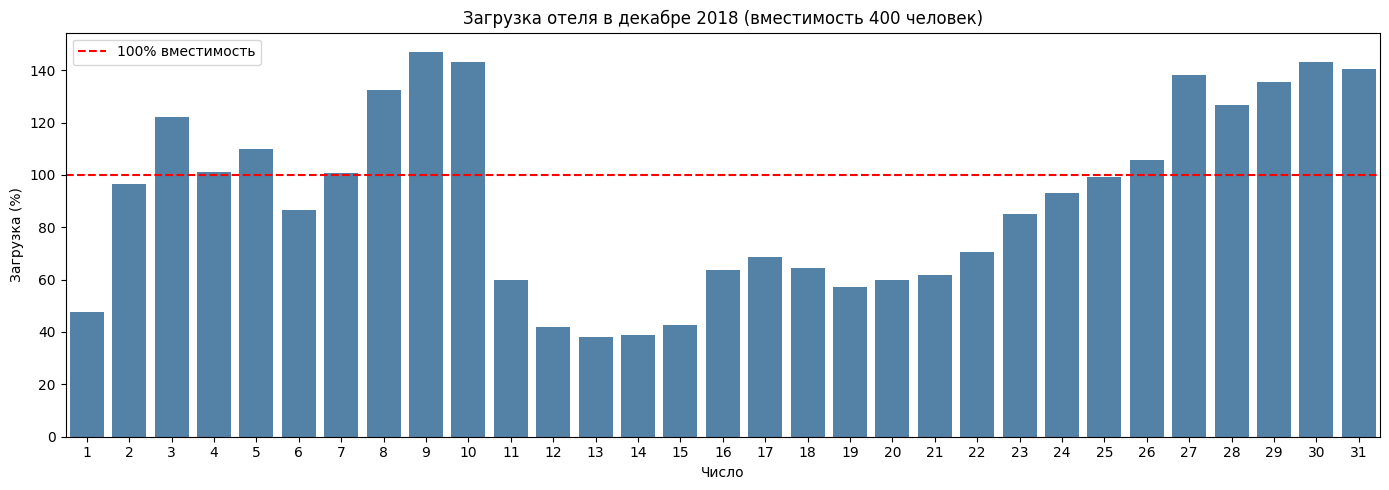

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/hotels.csv')
confirmed = df[df['status'] == 'Not_Canceled'].copy()

confirmed['safe_date'] = confirmed.apply(
    lambda r: 28 if r['month'] == 2 and r['date'] > 28 else r['date'], axis=1
)
confirmed['checkin'] = pd.to_datetime(
    confirmed[['year', 'month']].assign(day=confirmed['safe_date'])
)
confirmed['nights'] = confirmed['weekend_nights'] + confirmed['week_nights']
confirmed['checkout'] = confirmed['checkin'] + pd.to_timedelta(confirmed['nights'], unit='D')
confirmed['guests'] = confirmed['n_adults'] + confirmed['n_children']

# Декабрь 2018
dec_2018 = pd.date_range('2018-12-01', '2018-12-31')
occupancy = []

for day in dec_2018:
    active = confirmed[(confirmed['checkin'] <= day) & (confirmed['checkout'] > day)]
    occupancy.append({
        'date': day,
        'guests': active['guests'].sum(),
        'occupancy_pct': active['guests'].sum() / 400 * 100
    })

occ_df = pd.DataFrame(occupancy)

# График
plt.figure(figsize=(14, 5))
sns.barplot(data=occ_df, x=occ_df['date'].dt.day, y='occupancy_pct', color='steelblue')
plt.axhline(y=100, color='red', linestyle='--', label='100% вместимость')
plt.xlabel('Число')
plt.ylabel('Загрузка (%)')
plt.title('Загрузка отеля в декабре 2018 (вместимость 400 человек)')
plt.legend()
plt.tight_layout()
plt.show()